In [43]:
import micasense.imageset as imageset
import micasense.capture as capture
import cv2
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils
import os, glob
import json
import tqdm
import pickle #This library will maintain the format as well
import importlib
import radiometric_calib_utils
import mutils
import extract_spectral
importlib.reload(radiometric_calib_utils)
importlib.reload(mutils)
importlib.reload(extract_spectral)
import radiometric_calib_utils as rcu
import mutils
import extract_spectral as espect
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from math import ceil

- sunglint correction has to be conducted pixel-wise method
- because glint patterns appear to be randomised spatially, and autocorrelations may be weak, except for under the circumstances of gravity waves
- an algorithm which can account for randomly distributed glint patterns is more robust than one that is dependent on autocorrelations because waves are quite dynamic
- waves have different wavelengths, wave slopes have different tilt and azimuth
- the autocorrelation patterns may also not be consistent across space if there are different wind directions --> variable wave attributes which results in variable sun glint distributions

### Does glitter spectra for turbid and non-turbid waters differ?
- if glitter spectra for turbid and non-turbid waters differ, we can have texture/context-aware corrections
- otherwise, rely on neighbourhood information

# Plotting bboxes on images

For older versions of `get_training_data.py`, the plots for the bboxes textfiles were not saved in *saved_plots*, so we will need to generate plots for those bboxes with no saved plots in *saved_plots*. 

Run `mutils.get_saved_bboxes_complement()`

In [14]:
mutils.get_saved_bboxes_complement()

['saved_bboxes\\1stSur6Apr_F1_RawImg_IMG_0002_1.txt',
 'saved_bboxes\\1stSur6Apr_F1_RawImg_IMG_0003_1.txt',
 'saved_bboxes\\1stSur6Apr_F1_RawImg_IMG_0004_1.txt']

In [44]:
ES = espect.VerifyBboxes(r"saved_bboxes_complement", 
                         assign_new_dir=r"C:\Users\PAKHUIYING\Documents\sunglint_correction",split_iter=3)
ES.store_bboxes()

{'C:\\Users\\PAKHUIYING\\Documents\\sunglint_correction\\1stSur6Apr\\F1\\RawImg': {'IMG_0002_1.tif': {'shore': [[232,
     513],
    [512, 739]]},
  'IMG_0003_1.tif': {'shore': [[425, 203], [603, 351]]},
  'IMG_0004_1.tif': {'water_glint': [[19, 168], [124, 254]],
   'water': [[603, 93], [635, 125]],
   'shore': [[393, 394], [544, 529]]}}}

In [37]:
ES = espect.VerifyBboxes(r"saved_bboxes_complement")
ES.store_bboxes()

{'D:/EPMC_flight/1stSur6Apr/F1/RawImg': {'IMG_0002_1.tif': {'shore': [[232,
     513],
    [512, 739]]},
  'IMG_0003_1.tif': {'shore': [[425, 203], [603, 351]]},
  'IMG_0004_1.tif': {'water_glint': [[19, 168], [124, 254]],
   'water': [[603, 93], [635, 125]],
   'shore': [[393, 394], [544, 529]]}}}

## Plot bboxes using the saved bboxes text files

In [28]:
ES = espect.VerifyBboxes(r"saved_bboxes_complement")
ES.plot_bboxes(show_n = None,figsize=(10,20),save=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


# Inspect bboxes

In [ ]:
ES = espect.ExtractSpectral(r"saved_bboxes_complement")
img_bboxes = ES.store_bboxes()
img_bboxes

# Plot spectral for each category of bboxes

In [29]:
wavelengths = mutils.sort_bands_by_wavelength()
wavelengths_idx = np.array([i[0] for i in wavelengths])
wavelengths = {i[0]:i[1] for i in wavelengths}
wavelengths

{5: 444,
 0: 475,
 6: 531,
 1: 560,
 7: 650,
 2: 668,
 8: 705,
 4: 717,
 9: 740,
 3: 842}

In [2]:
ES = espect.ExtractSpectral(r"saved_bboxes")
img_bboxes = ES.store_bboxes()
warp_mode = cv2.MOTION_HOMOGRAPHY
img_type = "reflectance"
parent_dir = list(img_bboxes)[1]
print(parent_dir)
img_fp = list(img_bboxes[parent_dir])[-1]
print(img_fp)
fp = os.path.join(parent_dir,img_fp)
print(fp)
cap = mutils.import_captures(fp)
warp_matrices = cap.get_warp_matrices()
cropped_dimensions,_ = imageutils.find_crop_bounds(cap,warp_matrices)
im_aligned = imageutils.aligned_capture(cap, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)
bboxes = img_bboxes[parent_dir][img_fp]

D:/EPMC_flight/2ndSur28Apr/F1/RawImg
IMG_0004_1.tif
D:/EPMC_flight/2ndSur28Apr/F1/RawImg\IMG_0004_1.tif


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


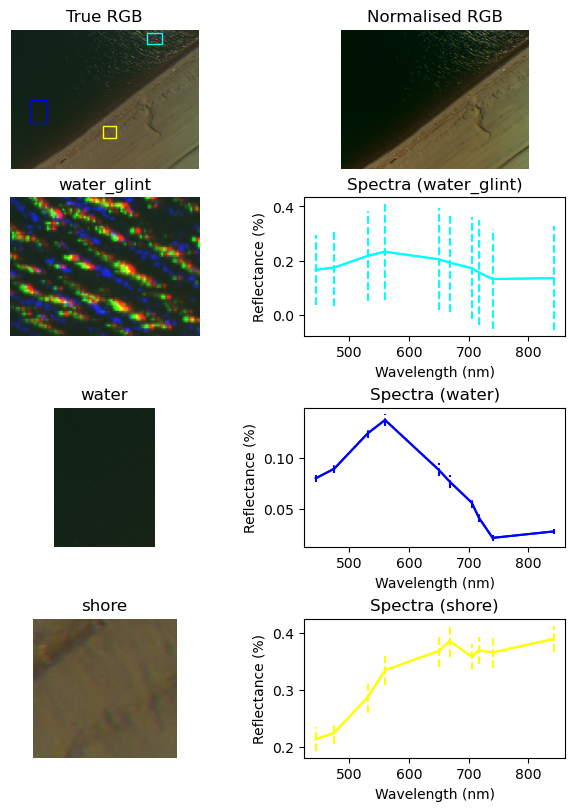

In [3]:
ES.plot_multispectral(parent_dir,img_fp,img_bboxes=img_bboxes,warp_matrices=warp_matrices, cropped_dimensions=cropped_dimensions)

### Plot spectral shape of a bbox category

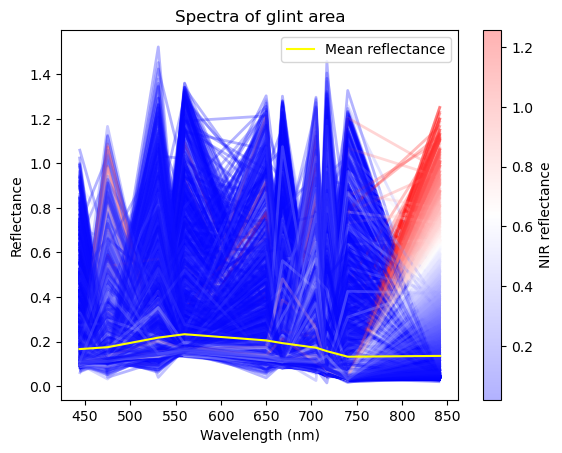

(0.01936886, 0.13540296, 1.2580082)

In [6]:
ES = espect.ExtractSpectral(r"saved_bboxes")
ES.plot_multiline(im_aligned,bboxes['water_glint'])

signal-to-ratio reduced significantly with sunglint

### Identify glint

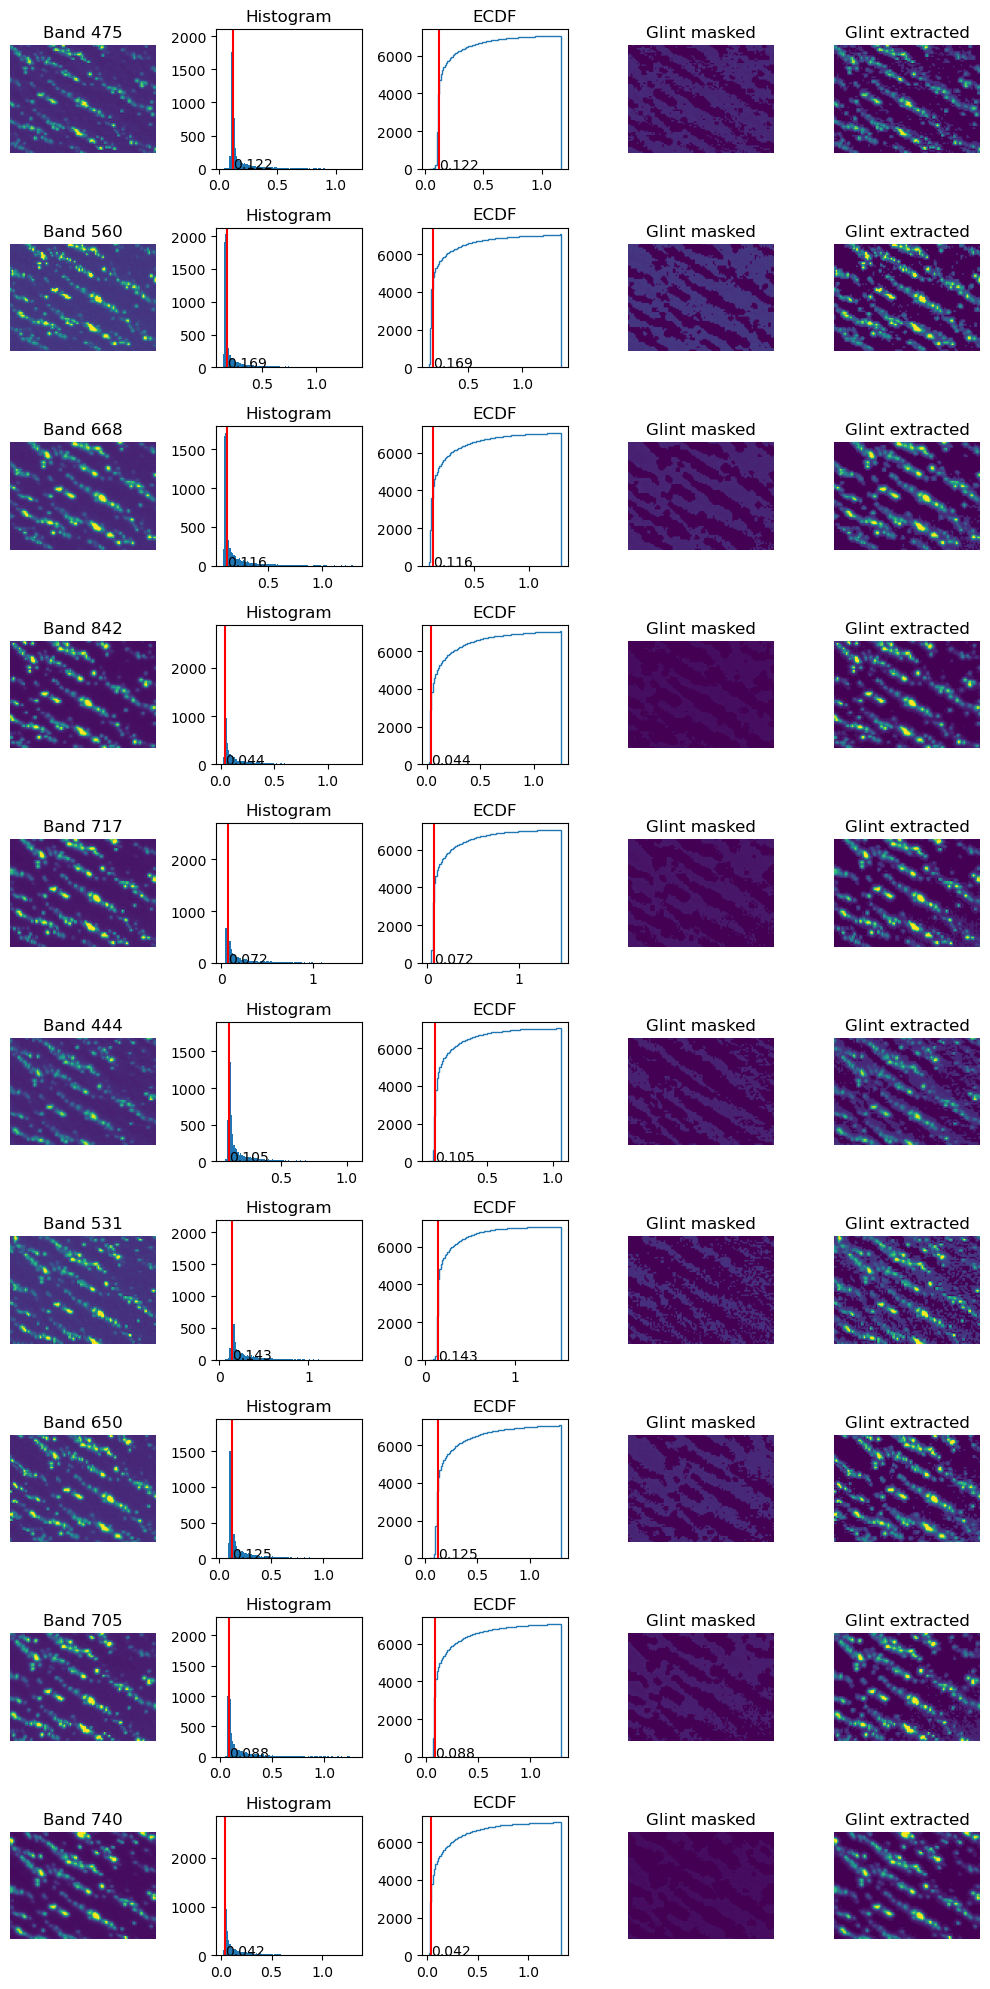

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


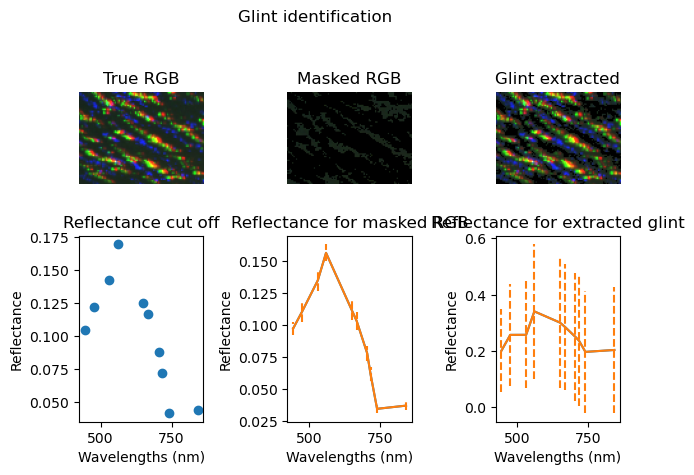

In [118]:
def identify_glint_all_bands(im_aligned,bbox,wavelengths,n_bins=200,percentile_threshold=90,mode="histogram"):
    """
    :param n_bins (int): basically determines how sensitive we want the threshold to be. The larger the n_bins (the more sensitive the threshold for glint cut off)
    :param mode (str): percentile or histogram. this determines the method for glint detection
    """
    ((x1,y1),(x2,y2)) = bbox
    if x1 > x2:
        x1, x2 = x2, x1
    if y1 > y2:
        y1,y2 = y2, y1

    nrow, ncol, c = im_aligned.shape
    glint_idxes_list = []
    rgb_bands = [2,1,0] #668, 560, 475 nm
    threshold_list = []
    extracted_glint_list = []
    glint_masked_list = []

    if mode == 'histogram':
        fig, axes = plt.subplots(c,5,figsize=(10,20))
        for i in range(c):
            band_i = im_aligned[y1:y2,x1:x2,i]
            band_i_flatten = band_i.flatten()
            axes[i,0].imshow(band_i,vmin=0,vmax=1)
            axes[i,0].axis('off')
            axes[i,0].set_title(f'Band {wavelengths[i]}')
            count,bins,_ = axes[i,1].hist(band_i_flatten,bins=n_bins)
            threshold_y = np.argmax(count)
            threshold_x = bins[threshold_y+1] #to get the right hand range of the bins
            threshold_list.append(threshold_x)
            axes[i,1].axvline(threshold_x, color='r')
            axes[i,1].text(threshold_x, threshold_y, f'{threshold_x:.3f}')
            axes[i,1].set_title('Histogram')
            axes[i,2].hist(band_i_flatten,n_bins, histtype='step',cumulative=True)
            axes[i,2].set_title('ECDF')
            axes[i,2].axvline(threshold_x, color='r')
            axes[i,2].text(threshold_x, threshold_y, f'{threshold_x:.3f}')

            # glint_masked = np.where(band_i> threshold_x,0,band_i)
            glint_idxes = np.argwhere(band_i>threshold_x)
            glint_idxes_list.append(glint_idxes)
            glint_masked = band_i.copy()
            glint_masked[(glint_idxes[:,0],glint_idxes[:,1])] = 0
            glint_extracted = band_i - glint_masked
            
            glint_masked_list.append(glint_masked)
            extracted_glint_list.append(glint_extracted)

            axes[i,3].imshow(glint_masked,vmin=0,vmax=1)
            axes[i,3].axis('off')
            axes[i,3].set_title('Glint masked')

            
            axes[i,4].imshow(glint_extracted,vmin=0,vmax=1)
            axes[i,4].axis('off')
            axes[i,4].set_title('Glint extracted')
            

        plt.tight_layout()
        plt.show()
    
    else:
        percentile_method='nearest'
        fig, axes = plt.subplots(c,5,figsize=(10,20))
        for i in range(c):
            band_i = im_aligned[y1:y2,x1:x2,i]
            band_i_flatten = band_i.flatten()
            
            axes[i,0].imshow(band_i,vmin=0,vmax=1)
            axes[i,0].axis('off')
            axes[i,0].set_title(f'Band {wavelengths[i]}')
            
            glint_percentile = np.percentile(band_i_flatten,percentile_threshold,interpolation=percentile_method)
            threshold_list.append(glint_percentile)
            axes[i,1].hist(band_i_flatten,bins=n_bins)
            axes[i,1].axvline(glint_percentile, color='r')
            axes[i,1].set_title(f'Histogram ({glint_percentile:.3f})')

            axes[i,2].hist(band_i_flatten,n_bins, histtype='step',cumulative=True)
            axes[i,2].set_title(f'ECDF ({glint_percentile:.3f})')
            axes[i,2].axvline(glint_percentile, color='r')
            
            # glint_masked = np.where(band_i> glint_percentile,0,band_i)
            glint_idxes = np.argwhere(band_i>glint_percentile)
            glint_idxes_list.append(glint_idxes)
            glint_masked = band_i.copy()
            glint_masked[(glint_idxes[:,0],glint_idxes[:,1])] = 0
            glint_extracted = band_i - glint_masked

            glint_masked_list.append(glint_masked)
            extracted_glint_list.append(glint_extracted)

            axes[i,3].imshow(glint_masked,vmin=0,vmax=1)
            axes[i,3].axis('off')
            axes[i,3].set_title('Glint masked')
            
            axes[i,4].imshow(glint_extracted,vmin=0,vmax=1)
            axes[i,4].axis('off')
            axes[i,4].set_title('Glint extracted')
        plt.tight_layout()
        plt.show()

    # concatenate glint_idxes
    # concatenate_glint_idxes = np.unique(np.vstack([glint_idxes_list[i] for i in rgb_bands]),axis=0) #in order of band 2,1,0
    concatenate_glint_idxes = np.unique(np.vstack(glint_idxes_list[:3]),axis=0) #in order of band 2,1,0
    # get rgb image
    rgb_image = np.take(im_aligned[y1:y2,x1:x2,:],rgb_bands,axis=2)
    # copy of of rgb
    rgb_image_copy = rgb_image.copy()
    rgb_list = []
    for i in range(len(rgb_bands)):
        im_copy = rgb_image_copy[:,:,i]
        im_copy[(concatenate_glint_idxes[:,0],concatenate_glint_idxes[:,1])] = 0
        rgb_list.append(im_copy)
    
    rgb_masked = np.stack(rgb_list,axis=2)
    glint_extracted = rgb_image - rgb_masked

    fig, axes = plt.subplots(2,3)
    axes[0,0].imshow(rgb_image)
    axes[0,0].set_title('True RGB')
    axes[0,1].imshow(rgb_masked)
    axes[0,1].set_title('Masked RGB')
    axes[0,2].imshow(glint_extracted)
    axes[0,2].set_title('Glint extracted')
    for ax in axes[0,:]:
        ax.axis('off')
    fig.suptitle('Glint identification')
    
    # sort y values based on wavelengths
    axes[1,0].plot(list(wavelengths.values()),[threshold_list[i] for i in list(wavelengths)],'o')
    axes[1,0].set_title('Reflectance cut off')

    # store a list of tuple where (mean of reflectance, sd of reflctance)
    extracted_glint_list = [(np.mean(i[i>0]), np.sqrt(np.var(i[i>0],axis=0))) for i in extracted_glint_list]
    glint_masked_list = [(np.mean(i[i>0]), np.sqrt(np.var(i[i>0],axis=0))) for i in glint_masked_list]
    # sort based on wavelengths in ascending manner
    extracted_glint_list = [extracted_glint_list[i] for i in list(wavelengths)]
    glint_masked_list = [glint_masked_list[i] for i in list(wavelengths)]

    plot_statistics = {1: glint_masked_list, 2: extracted_glint_list}
    for k, v in plot_statistics.items():
        axes[1,k].plot(list(wavelengths.values()), [i[0] for i in v])
        eb = axes[1,k].errorbar(list(wavelengths.values()),[i[0] for i in v],yerr=[i[1] for i in v])
        eb[-1][0].set_linestyle('--')

    axes[1,1].set_title('Reflectance for masked RGB')
    axes[1,2].set_title('Reflectance for extracted glint')
    for ax in axes[1,:]:
        ax.set_xlabel('Wavelengths (nm)')
        ax.set_ylabel('Reflectance')

    plt.tight_layout()
    plt.show()
    return

identify_glint_all_bands(im_aligned,bboxes['water_glint'],wavelengths,n_bins=100,percentile_threshold=90,mode='histogram')
    

From the histogram and CDF, we know that the higher the reflectance values, the less frequent it occurs, the more gentle the gradient of the CDF.

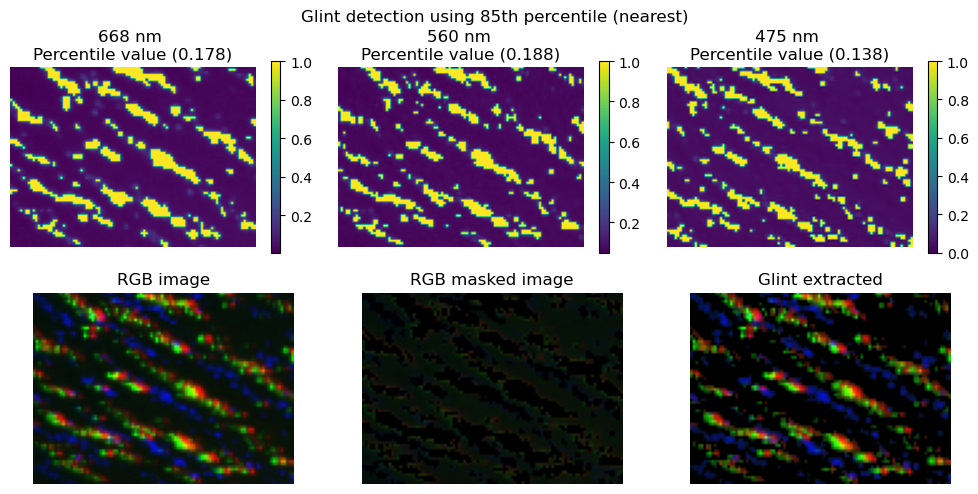

In [18]:
ES = espect.ExtractSpectral(r"saved_bboxes")
bin_mask = ES.identify_glint(im_aligned,bboxes['water_glint'],percentile_threshold=85,normalisation=True,mode="rgb")

- glint distribution is spatially similar across the RGB bands but has a bit of offset, possibly due to diffraction of light. But in terms of reflectance magnitude, there is high correlation across the RGB bands at the glint regions (very high reflectance at the glint regions, and low reflectance at non-glint regions)
- NIR band and 668 nm (band 2) are more sensitive to turbid regions compared to 560 nm and 475 nm (bands 1 and 0 respectively), as turbid regions show up as higher reflectance too
- Using NIR band to determine glint threshold is not good at masking glint regions due to the nature of light diffraction (as shown in the `mode='nir'`) because the glint distribution is different at different bands
- using `percentile_threshold` is more robust under different image contrast thanusing absolute reflectance threshold

1. concatenate the identified glint regions indices for those regions selected by `_glint` bboxes
2. get the spectral reflectances for all bands (?) or rgb bands?
3. get the corresponding nearest neighbourhood band reflectances with no glint for each index which will serve as the y-value
4. mask those glint regions using the indices
5. interpolate the masked areas with non-glint regions using the nearest neighbourhood region (inpainting)
6. train a U-net model? with pairs of corrected images and uncorrected images. Or just train a XGBoost model with bands with glint as the features, and non-glint as the `y`

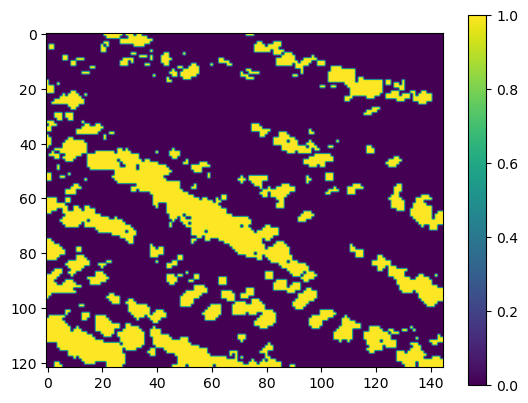

In [216]:
def inpainting(im_aligned,mask):
    """ 
    :param im_aligned (np.ndarray): 10 bands in band order i.e. band 1,2,3,4,5,6,7,8,9,10
    :param mask (np.ndarray): a binary mask, of same size as that of input image, where non-zero pixels corresponds to the area which is to be inpainted
    TODO 
        1. use a horizontal line across the original and corrected image to show the location of where spectrum is drawn
        2. add spectrum of the horizontal line
        3. use cv.INPAINT_NS or CV.INPAINT_TELEA method for inpainting
    """

In [3]:
with open(r'saved_bboxes\1stSur6Apr_F1_RawImg_IMG_0002_1.txt', 'r') as fp:
    data = json.load(fp)

data

{'D:/EPMC_flight/1stSur6Apr/F1/RawImg\\IMG_0002_1.tif': {'turbid_glint': None,
  'water_glint': None,
  'turbid': None,
  'water': None,
  'shore': [[232, 513], [512, 739]]}}

In [6]:
cap = mutils.import_captures(list(data)[0])
cap.num_bands

10

In [7]:
cap.images

In [17]:
x = np.ones((3,3,3))
x = np.multiply(x,np.array([1,2,3]))
X = np.take(x,[2,1,0],axis=2)
X[:,:,2]

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [4]:
x = np.linspace(1,9,9).reshape(3,3,1)
x = np.repeat(x,3,axis=2)
# X = x[1:3,0:2,:]
X = x.reshape(-1,3)
X[:,0]

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [47]:
x = np.ones((3,3,3))
x = np.multiply(x,np.array([1,2,3]))
X = x[:,:,np.array([2,1,0])]
np.mean(X,axis=(0,1))
np.var(X,axis=(0,1))

array([0., 0., 0.])

In [176]:
indices = np.linspace(0,8,9,dtype=int)
indices
idx = np.unravel_index(indices,(3,3))
print(idx)
X = np.linspace(1,25,25).reshape(5,5)
X[idx] = 0
idxes = [idx,idx,idx]
unique_idxes = np.unique(np.vstack([np.column_stack(i) for i in idxes]),axis=0)
unique_idxes[:,0]

(array([0, 0, 0, 1, 1, 1, 2, 2, 2], dtype=int64), array([0, 1, 2, 0, 1, 2, 0, 1, 2], dtype=int64))


array([0, 0, 0, 1, 1, 1, 2, 2, 2], dtype=int64)

In [144]:
x = np.linspace(0,0.1,9)
print(x)
np.argwhere(x > 0.05)

[0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1   ]


array([[5],
       [6],
       [7],
       [8]], dtype=int64)

In [200]:
x = np.linspace(0,500,100)
np.argwhere(x>np.percentile(x,95))
print(np.percentile(x,95,interpolation='nearest'))
print(np.percentile(x,95))

474.7474747474747
474.99999999999994


In [201]:
np.__version__

'1.21.6'